In [1]:
import pandas as pd
import yaml
import random
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import LayerNormalization,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.models import model_from_yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

np.set_printoptions(suppress=True)

In [2]:
def readFile(filePath):
    lemma_result = pd.read_csv(filePath)
    print(lemma_result.shape)
    return lemma_result

In [3]:
def checkLength(max_feat, file):
    leng = 0
    sentence = []
    allData = file['cleaned_review']

    max_fatures = max_feat
    tokenizer = Tokenizer(num_words=max_fatures, split=' ') 
    tokenizer.fit_on_texts(allData.values)
    X1 = tokenizer.texts_to_sequences(allData.values)
    
    for i in X1:
        if len(i)>leng:
            leng = len(i)
            sentence = i
    print(leng)
    print(sentence)
    return leng

In [4]:
def beforeCreateModel(max_feat,dataset,max_length):
    max_fatures = max_feat #จำนวนคำที่ใช้ใน model
    tokenizer = Tokenizer(num_words=max_fatures, split=' ') 
    tokenizer.fit_on_texts(dataset['cleaned_review'].values)
    X1 = tokenizer.texts_to_sequences(dataset['cleaned_review'].values)
    print(len(tokenizer.word_index))
    feat = pad_sequences(X1, padding='pre',maxlen=max_length) # 505 = max_length in sentence
    target = dataset['Label'].values

    return feat,target,tokenizer

In [5]:
def createModelLSTM(embed_dim,lstm_out,max_feat,input_length):
    embed_dim = embed_dim
    lstm_out = lstm_out
    model = Sequential() #Create Model
    model.add(Embedding(input_dim = max_feat ,output_dim = embed_dim ,input_length = input_length)) #Input Layer
    model.add(LSTM(lstm_out, dropout=0.5)) #1st hidden Layer
    model.add(Dropout(0.5))
    model.add(Dense(10,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid')) # Output Layer
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [6]:
def trainModel(model,feat,target,validation_split,epochs,batch_size):
    random.seed(10)
    history = model.fit(feat, target,validation_split=validation_split, epochs = epochs, batch_size=batch_size)
    return history

In [7]:
def evaluateModel(model,feat,target,batch_size):
    score,acc = model.evaluate(feat, target, verbose = 2, batch_size = batch_size)
    print("score: %.2f" % (score))
    print("acc: %.2f" % (acc))

In [8]:
def plotLoss(history):
    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(loss_values)+1)

    plt.plot(epochs, loss_values, label='Training Loss')
    plt.plot(epochs, val_loss_values, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [9]:
def saveModel(model):
    # serialize model to YAML
    model_yaml = model.to_yaml()
    with open("Summary.yaml", "w") as yaml_file:
        yaml_file.write(model_yaml)
    # serialize weights to HDF5
    model.save_weights("Weights.h5")
    print("Saved model to disk")

In [10]:
def loadModel(yamlPathName, h5PathName):
    with open(yamlPathName+'.yaml', 'r') as yaml_file:
        print(yamlPathName)
        loaded_model_yaml = yaml_file.read()
        loaded_model = model_from_yaml(loaded_model_yaml)
        loaded_model.load_weights(h5PathName+'.h5')
    loaded_model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return loaded_model

In [11]:
def filterAndShow(filter1, filter2, modelOutput, labelTest):
    print(modelOutput)
    test = []
    test_y = []

    for i in range(len(modelOutput)):
        if(modelOutput[i] <filter1 or modelOutput[i]>filter2):
            test.append(modelOutput[i])
            test_y.append(labelTest[i])

    test1 = np.array(test)
    testy1 = np.array(test_y)
    print(testy1)
    print(test1.shape)
    print(testy1.shape)
    showConfusionMatrix(testy1, test1)

In [12]:
def showConfusionMatrix(trueLabel,resultToShow):
    labels = ['positive','negative']
    cm = confusion_matrix(y_true=trueLabel , y_pred=resultToShow>0.5)
    print(cm)

In [13]:
def showWordWithCode(dataToMap, tokenizer): #dataToMap = list of sentiment
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items())) # map id to all word in dic
    print(reverse_word_map)
    
    def sequence_to_text(list_of_indices):
        # Looking up words in dictionary
        words = [reverse_word_map.get(letter) for letter in list_of_indices]
        return(words)
    
    my_texts = list(map(sequence_to_text, dataToMap))
    #my_texts
    return reverse_word_map

In [14]:
def saveSentimentAndResult(sentenceToSave, resultToSave):
    sen_temp = ""
    SentimentSave = []
    for one_sentence in sentenceToSave:
        for word in one_sentence:
            if isinstance(word, str):
                sen_temp = sen_temp + " " + word
            
        SentimentSave.append(sen_temp)
        sen_temp = ""
            
    #make 1 Dim predict result
    resultSave = []
    for arr_result in resultToSave:
        for result in arr_result:
            #print(result)
            resultSave.append(result)
            
    data = {'lemma_review': SentimentSave, 'predict score': resultSave}
    toFile = pd.DataFrame(data)
    toFile.to_csv("./for_compare.csv", index=False)

Test

In [15]:
MAX_FEATURE = 3800

In [16]:
path = "../Clean/lemma_result_rotten_data_text_len_more_12.csv"
x = readFile(path)

(10000, 2)


In [17]:
max_length = checkLength(MAX_FEATURE,x)

28
[1891, 365, 1931, 576, 557, 146, 174, 521, 66, 148, 724, 81, 1261, 197, 3218, 28, 337, 7, 11, 619, 268, 2083, 296, 2321, 829, 1422, 4, 170]


In [18]:
feat,target,tokenizer = beforeCreateModel(max_feat=MAX_FEATURE,dataset=x,max_length=max_length)

feat,target

20240


(array([[   0,    0,    0, ..., 1900,  107, 1786],
        [   0,    0,    0, ..., 2723,  843,   59],
        [   0,    0,    0, ...,  989, 3293,  548],
        ...,
        [   0,    0,    0, ..., 1496,  200,  261],
        [   0,    0,    0, ...,   29,   62,   85],
        [   0,    0,    0, ...,  155,  691, 1789]]),
 array([1, 0, 1, ..., 1, 0, 1], dtype=int64))

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(feat,target, test_size = 0.2, train_size = 0.8, random_state = 10)

LSTM

In [20]:
embed_dim=128
lstm_out=15

model = createModelLSTM(embed_dim=embed_dim,lstm_out=lstm_out,max_feat=MAX_FEATURE,input_length=feat.shape[1])
print("Input Shape is " + str(feat.shape[1]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 128)           486400    
_________________________________________________________________
lstm (LSTM)                  (None, 15)                8640      
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 495,211
Trainable params: 495,211
Non-trainable params: 0
_________________________________________________________________
None
Input Shape is 28


In [21]:
#history = trainModel(model,feat=X_train,target=Y_train,validation_split=0.2,epochs=15,batch_size=32)
random.seed(10)
history = model.fit(X_train, 
                    Y_train,
                    validation_data=(X_test, Y_test), 
                    epochs = 10, 
                    batch_size=32)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 5s 657us/sample - loss: 0.6722 - accuracy: 0.5846 - val_loss: 0.6057 - val_accuracy: 0.6920
Epoch 2/10
8000/8000 [==============================] - 3s 398us/sample - loss: 0.5260 - accuracy: 0.7580 - val_loss: 0.5791 - val_accuracy: 0.7015
Epoch 3/10
8000/8000 [==============================] - 3s 418us/sample - loss: 0.4275 - accuracy: 0.8251 - val_loss: 0.6128 - val_accuracy: 0.6950
Epoch 4/10
8000/8000 [==============================] - 3s 405us/sample - loss: 0.3681 - accuracy: 0.8589 - val_loss: 0.6443 - val_accuracy: 0.6965
Epoch 5/10
8000/8000 [==============================] - 3s 392us/sample - loss: 0.3118 - accuracy: 0.8890 - val_loss: 0.7239 - val_accuracy: 0.6910
Epoch 6/10
8000/8000 [==============================] - 3s 395us/sample - loss: 0.2712 - accuracy: 0.9079 - val_loss: 0.7526 - val_accuracy: 0.6930
Epoch 7/10
8000/8000 [==============================] - 3s 402us

In [22]:
evaluateModel(model,feat=X_test,target=Y_test,batch_size=32)

2000/2000 - 0s - loss: 0.9959 - accuracy: 0.6820
score: 1.00
acc: 0.68


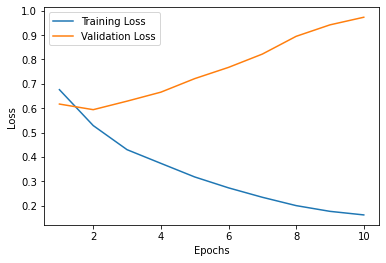

In [23]:
plotLoss(history=history)

In [24]:
result=model.predict(X_test)

In [25]:
showConfusionMatrix(trueLabel=Y_test,resultToShow=result)

[[682 279]
 [378 661]]


Web Test

In [24]:
def beforeCreateModelTest(max_feat,dataset,max_length):
    max_fatures = max_feat
    X1 = tokenizer.texts_to_sequences(dataset['cleaned_review'].values)
    print(len(tokenizer.word_index))
    feat = pad_sequences(X1, padding='pre',maxlen=max_length) # 505 = max_length in sentence
    target = dataset['Label'].values

    return feat,target

In [25]:
path = "../Clean/test_data.csv"
test = readFile(path)

(10, 2)


In [26]:
max_length = 28

In [27]:
feat_test,target_test = beforeCreateModelTest(max_feat=MAX_FEATURE,dataset=test,max_length=max_length)

17902


In [28]:
t_result = model.predict(feat_test)

In [29]:
showConfusionMatrix(trueLabel=target_test,resultToShow=t_result)

[[1 2]
 [1 6]]


In [30]:
saveModel(model)

Saved model to disk


In [34]:
test = loadModel('./main_1_GRU/Summary','./main_1_GRU/Weights')

./main_1_GRU/Summary


C:\Users\gotj\miniconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\keras\saving\model_config.py:76: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


In [35]:
result = test.predict(X_test)

In [37]:
showConfusionMatrix(trueLabel=Y_test,resultToShow=target_test) #LSTM no filter

[[1 2]
 [1 6]]
